# NLP & Binary Classification: IMDB sentiment analysis data
https://keras.io/datasets/


** Dataset Information: **

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative)

** Attribute Information: (1 features and 1 class) **

- review: preprocessed, a sequence of word indexes
- sentiment: positive/negative

** Objective of this project **

predict whether a review is thumbs-up or thumbs-down

# Data

In [1]:
import numpy as np
from keras.datasets import imdb
from matplotlib import pyplot as plt
%matplotlib inline

# load Data
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Using TensorFlow backend.


17465344/17464789 [==============================] - 1s 0us/step


In [0]:
# feature (review)
print(X.shape,y.shape)
#X[0]

(50000,) (50000,)


In [0]:
# class (setiment)
print(np.unique(y_train,return_counts=True))

(array([0, 1]), array([12500, 12500]))


In [0]:
# total unique words
print(len(np.unique(np.hstack(X))))

88585


Review length: Mean 234.8 words (172.9)


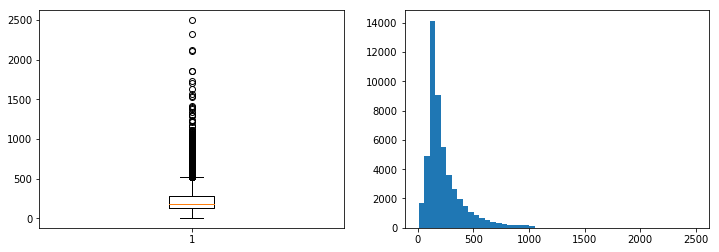

In [0]:
# review length
result = [len(x) for x in X]
print("Review length: Mean %.1f words (%.1f)" % (np.mean(result), np.std(result)))

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.boxplot(result)
plt.subplot(1, 2, 2)
plt.hist(result,bins=50)
plt.show()

# Data Preprocessing

In [0]:
# fix random seed for reproducibility
seed = 101
np.random.seed(seed)

In [3]:
# load the top 20000 words (vocabulary)
top_words = 20000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
#X_train[0]

(25000,) (25000,) (25000,) (25000,)


In [4]:
# truncate reviews at 500 words and zero padding for shorter one
from keras.preprocessing import sequence
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)
#X_train[0]

(25000, 500) (25000, 500)


# 1. MLP

In [0]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Conv1D,MaxPooling1D,LSTM,Bidirectional,Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report

### Model Train

In [28]:
np.random.seed(seed)
K.clear_session()

# create the model
model = Sequential()
model.add(Embedding(top_words, 128, input_length=X_train.shape[1]))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, 
          batch_size=128, verbose=2, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               16000250  
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 18,560,501
Trainable params: 18,560,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/50
 - 9s - loss: 0.5019 - acc: 0.7406 - val_loss: 0.2844 - val_acc:

### Model Evaluation with Test Set

In [0]:
def model_eval():
  # predict class with test set
  y_pred_test =  model.predict_classes(X_test, batch_size=128, verbose=0)
  print('Accuracy: {:0.1f}%'.format(accuracy_score(y_test,y_pred_test)*100))
  print('roc auc: {:0.3f}'.format(roc_auc_score(y_test,y_pred_test)))
  
  #classification report
  print('\n')
  print(classification_report(y_test, y_pred_test))

  #confusion matrix
  confmat = confusion_matrix(y_test, y_pred_test)

  fig, ax = plt.subplots(figsize=(2.5, 2.5))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
      for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.tight_layout()

Accuracy: 87.3%
roc auc: 0.873


             precision    recall  f1-score   support

          0       0.87      0.87      0.87     12500
          1       0.87      0.87      0.87     12500

avg / total       0.87      0.87      0.87     25000



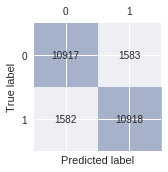

In [29]:
model_eval()

# 2. CNN

### Model Train

In [37]:
np.random.seed(seed)
K.clear_session()

# create the model
model = Sequential()
model.add(Embedding(top_words, 128, input_length=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(filters=250, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, 
          batch_size=128, verbose=2, callbacks=[early_stop])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 250)          96250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 250)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 62500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               15625250  
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
__________

### Model Evaluation with Test Set

Accuracy: 86.9%
roc auc: 0.869


             precision    recall  f1-score   support

          0       0.85      0.89      0.87     12500
          1       0.89      0.85      0.87     12500

avg / total       0.87      0.87      0.87     25000



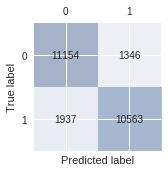

In [38]:
model_eval()

# 3. RNN (lstm)

### Model Train

In [13]:
np.random.seed(seed)
K.clear_session()

# create the model
model = Sequential()
model.add(Embedding(top_words, 128, input_length=X_train.shape[1]))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, 
          batch_size=128, verbose=2, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,609,473
Trainable params: 2,609,473
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/50
 - 240s - loss: 0.4944 - acc: 0.7574 - val_loss: 0.4027 - val_acc: 0.8306
Epoch 2/50
 - 237s - loss: 0.3282 - acc: 0.8675 - val_loss: 0.3648 - val_acc: 0.8434
Epoch 3/50
 - 238s - loss: 0.2599 - acc: 0.8997 - val_loss: 0.3978 - val_acc: 0.8368
Epoch 4/50
 - 236s - loss: 0.2195 - acc: 0.9170 - val_loss: 0.3867 - val_acc: 0.8462
E

### Model Evaluation with Test Set

Accuracy: 85.0%
roc auc: 0.850


             precision    recall  f1-score   support

          0       0.84      0.87      0.85     12500
          1       0.86      0.83      0.85     12500

avg / total       0.85      0.85      0.85     25000



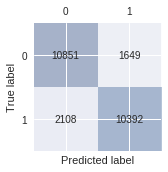

In [17]:
model_eval()

# 4. RNN (bidirectional lstm)

### Model Train

In [10]:
np.random.seed(seed)
K.clear_session()

# create the model
model = Sequential()
model.add(Embedding(top_words, 128, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, 
          batch_size=128, verbose=2, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,658,945
Trainable params: 2,658,945
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/50
 - 384s - loss: 0.4608 - acc: 0.7748 - val_loss: 0.3450 - val_acc: 0.8566
Epoch 2/50
 - 381s - loss: 0.3057 - acc: 0.8729 - val_loss: 0.4019 - val_acc: 0.8422
Epoch 3/50
 - 381s - loss: 0.2352 - acc

### Model Evaluation with Test Set

Accuracy: 85.9%
roc auc: 0.859


             precision    recall  f1-score   support

          0       0.87      0.84      0.86     12500
          1       0.85      0.87      0.86     12500

avg / total       0.86      0.86      0.86     25000



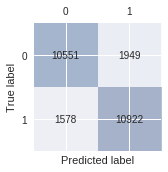

In [11]:
model_eval()

# 5. CNN + LSTM

### Model Train

In [6]:
np.random.seed(seed)
K.clear_session()

# create the model
model = Sequential()
model.add(Embedding(top_words, 128, input_length=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(filters=250, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')

# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, 
          batch_size=128, verbose=2, callbacks=[early_stop])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 250)          96250     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 250)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                80640     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,736,955
Trainable params: 2,736,955
Non-tra

### Model Evaluation with Test Set

Accuracy: 85.8%
roc auc: 0.858


             precision    recall  f1-score   support

          0       0.86      0.86      0.86     12500
          1       0.86      0.86      0.86     12500

avg / total       0.86      0.86      0.86     25000



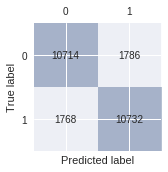

In [9]:
model_eval()